In [1]:
# # ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# # Verify you're in the right place
# !pwd
# !ls -la

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

In [4]:
df = pd.read_csv("03 Result Data Cleaning Part 3.csv")
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.set_index('Tanggal')
df = df[['Katulampa (air)', 'Depok (air)', 'Manggarai (air)']]
df.head()

,Katulampa (air),Depok (air),Manggarai (air)
Tanggal,,,
2021-10-16 00:00:00,10.0,80.0,555.0
2021-10-16 01:00:00,10.0,95.0,555.0
2021-10-16 02:00:00,10.0,95.0,555.0
2021-10-16 03:00:00,10.0,90.0,555.0
2021-10-16 04:00:00,10.0,90.0,560.0


# Data WITHOUT weather

In [5]:
# Create new dataframe for lagged features
lagged_data = pd.DataFrame(index=df.index)

# Target variable (current Manggarai)
lagged_data['Manggarai'] = df['Manggarai (air)']

# Significant Autoregresive Model
lagged_data['Manggarai Lag 1'] = df['Manggarai (air)'].shift(1)
lagged_data['Manggarai Lag 2'] = df['Manggarai (air)'].shift(2)
lagged_data['Manggarai Lag 3'] = df['Manggarai (air)'].shift(3)

# Cross-correlation lags for Depok (7-9 hours back)
lagged_data['Depok Lag 7'] = df['Depok (air)'].shift(7)
lagged_data['Depok Lag 8'] = df['Depok (air)'].shift(8)
lagged_data['Depok Lag 9'] = df['Depok (air)'].shift(9)

# Cross-correlation lags for Katulampa (12 hours back)
lagged_data['Katulampa Lag 11'] = df['Katulampa (air)'].shift(11)
lagged_data['Katulampa Lag 12'] = df['Katulampa (air)'].shift(12)
lagged_data['Katulampa Lag 13'] = df['Katulampa (air)'].shift(13)

# Check for missing values (due to shifting)
print(lagged_data.head())
print(f'\nLagged Data Shape: {lagged_data.shape}\n')
print('Missing values due to shifting:')
print(lagged_data.isnull().sum())

# Remove rows with missing values (caused by lagging)
lagged_data = lagged_data.dropna()
print(f"\nAfter removing missing values: {lagged_data.shape}")
lagged_data.head()

                     Manggarai  Manggarai Lag 1  Manggarai Lag 2  \
Tanggal                                                            
2021-10-16 00:00:00      555.0              NaN              NaN   
2021-10-16 01:00:00      555.0            555.0              NaN   
2021-10-16 02:00:00      555.0            555.0            555.0   
2021-10-16 03:00:00      555.0            555.0            555.0   
2021-10-16 04:00:00      560.0            555.0            555.0   

                     Manggarai Lag 3  Depok Lag 7  Depok Lag 8  Depok Lag 9  \
Tanggal                                                                       
2021-10-16 00:00:00              NaN          NaN          NaN          NaN   
2021-10-16 01:00:00              NaN          NaN          NaN          NaN   
2021-10-16 02:00:00              NaN          NaN          NaN          NaN   
2021-10-16 03:00:00            555.0          NaN          NaN          NaN   
2021-10-16 04:00:00            555.0          NaN

,Manggarai,Manggarai Lag 1,Manggarai Lag 2,Manggarai Lag 3,Depok Lag 7,Depok Lag 8,Depok Lag 9,Katulampa Lag 11,Katulampa Lag 12,Katulampa Lag 13
Tanggal,,,,,,,,,,
2021-10-16 13:00:00,570.0,570.0,565.0,560.0,85.0,85.0,90.0,10.0,10.0,10.0
2021-10-16 14:00:00,570.0,570.0,570.0,565.0,85.0,85.0,85.0,10.0,10.0,10.0
2021-10-16 15:00:00,570.0,570.0,570.0,570.0,80.0,85.0,85.0,10.0,10.0,10.0
2021-10-16 16:00:00,570.0,570.0,570.0,570.0,80.0,80.0,85.0,10.0,10.0,10.0
2021-10-16 17:00:00,570.0,570.0,570.0,570.0,80.0,80.0,80.0,10.0,10.0,10.0


In [8]:
feature_cols = ['Manggarai Lag 1', 'Manggarai Lag 2', 'Manggarai Lag 3',
                'Depok Lag 7', 'Depok Lag 8', 'Depok Lag 9',
                'Katulampa Lag 11', 'Katulampa Lag 12', 'Katulampa Lag 13']

split_index = int(len(lagged_data) * 0.95)

train_df = lagged_data[:split_index].copy()
test_df = lagged_data[split_index:].copy()

X_train = train_df[feature_cols]
y_train = train_df['Manggarai']
X_test = test_df[feature_cols]
y_test = test_df['Manggarai']

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (29650, 9)
X_test shape: (1561, 9)

y_train shape: (29650,)
y_test shape: (1561,)


In [17]:
# XGBoost parameters optimized for time series and GPU
xgb_params = {
    # GPU Configuration (comment out if GPU not available)
    'tree_method': 'gpu_hist',    # Use GPU for training
    'gpu_id': 0,   # GPU device ID
    
    # Core XGBoost parameters
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'rmse', # Evaluation metric
    
    # Tree parameters
    'max_depth': 6,   # Maximum tree depth
    'min_child_weight': 3, # Minimum sum of instance weight in a child
    'subsample': 0.8, # Subsample ratio of training instances
    'colsample_bytree': 0.8,    # Subsample ratio of columns when constructing each tree
    'colsample_bylevel': 0.8,   # Subsample ratio of columns for each level
    
    # Learning parameters
    'learning_rate': 0.1,  # Step size shrinkage
    'n_estimators': 1000,  # Number of boosting rounds
    'early_stopping_rounds': 50,# Early stopping
    
    # Regularization
    'reg_alpha': 0.1, # L1 regularization
    'reg_lambda': 1.0,# L2 regularization
    
    # Other parameters
    'random_state': 42,    # Random seed for reproducibility
    'n_jobs': -1,# Use all CPU cores for preprocessing
    'verbosity': 1    # Print progress
}

for key, value in xgb_params.items():
    print(f"  {key}: {value}")

  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  max_depth: 6
  min_child_weight: 3
  subsample: 0.8
  colsample_bytree: 0.8
  colsample_bylevel: 0.8
  learning_rate: 0.1
  n_estimators: 1000
  early_stopping_rounds: 50
  reg_alpha: 0.1
  reg_lambda: 1.0
  random_state: 42
  n_jobs: -1
  verbosity: 1


In [ ]:
# Create XGBoost regressor
model = xgb.XGBRegressor(**xgb_params)

# Train with early stopping
start_time = datetime.now()
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)
training_time = datetime.now() - start_time

print(f"\nTraining completed in: {training_time}")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")

[0]	validation_0-rmse:39.93322
[82]	validation_0-rmse:24.45546

Training completed in: 0:00:01.997298
Best iteration: 32
Best score: 24.2273


In [ ]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_mape = np.mean(np.abs((y_train - train_pred) / y_train)) * 100

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

print("TRAINING SET METRICS:")
print(f"  RMSE: {train_rmse:.4f} cm")
print(f"  MAE:  {train_mae:.4f} cm")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test_rmse:.4f} cm")
print(f"  MAE:  {test_mae:.4f} cm")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")


MODEL EVALUATION
TRAINING SET METRICS:
  RMSE: 15.7637 cm
  MAE:  4.1184 cm
  R²:   0.8794
  MAPE: 1.52%

TEST SET METRICS:
  RMSE: 24.2273 cm
  MAE:  4.7680 cm
  R²:   0.3089
  MAPE: 1.96%


In [32]:
# Calculate additional metrics
residuals_test = y_test - test_pred
print(f"\nADDITIONAL TEST METRICS:")
print(f"  Mean Residual: {np.mean(residuals_test):.4f} cm")
print(f"  Std Residual:  {np.std(residuals_test):.4f} cm")
print(f"  Max Error:     {np.max(np.abs(residuals_test)):.4f} cm")


ADDITIONAL TEST METRICS:
  Mean Residual: 0.8887 cm
  Std Residual:  24.2110 cm
  Max Error:     598.4069 cm


Most Important Features:
         feature  importance
 Manggarai Lag 1    0.490010
 Manggarai Lag 2    0.409021
     Depok Lag 7    0.031592
 Manggarai Lag 3    0.031013
     Depok Lag 9    0.011056
     Depok Lag 8    0.009828
Katulampa Lag 12    0.005932
Katulampa Lag 11    0.005848
Katulampa Lag 13    0.005699


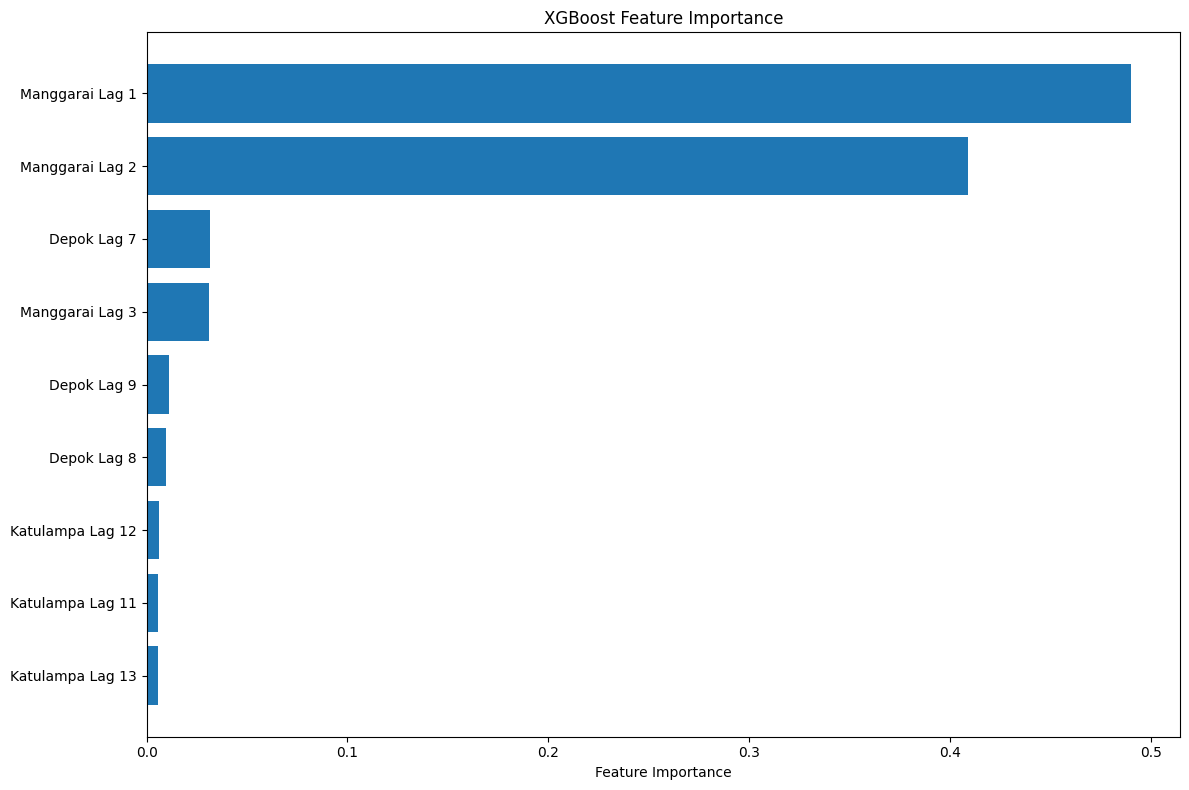

In [30]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most Important Features:")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Available evaluation results: ['validation_0']


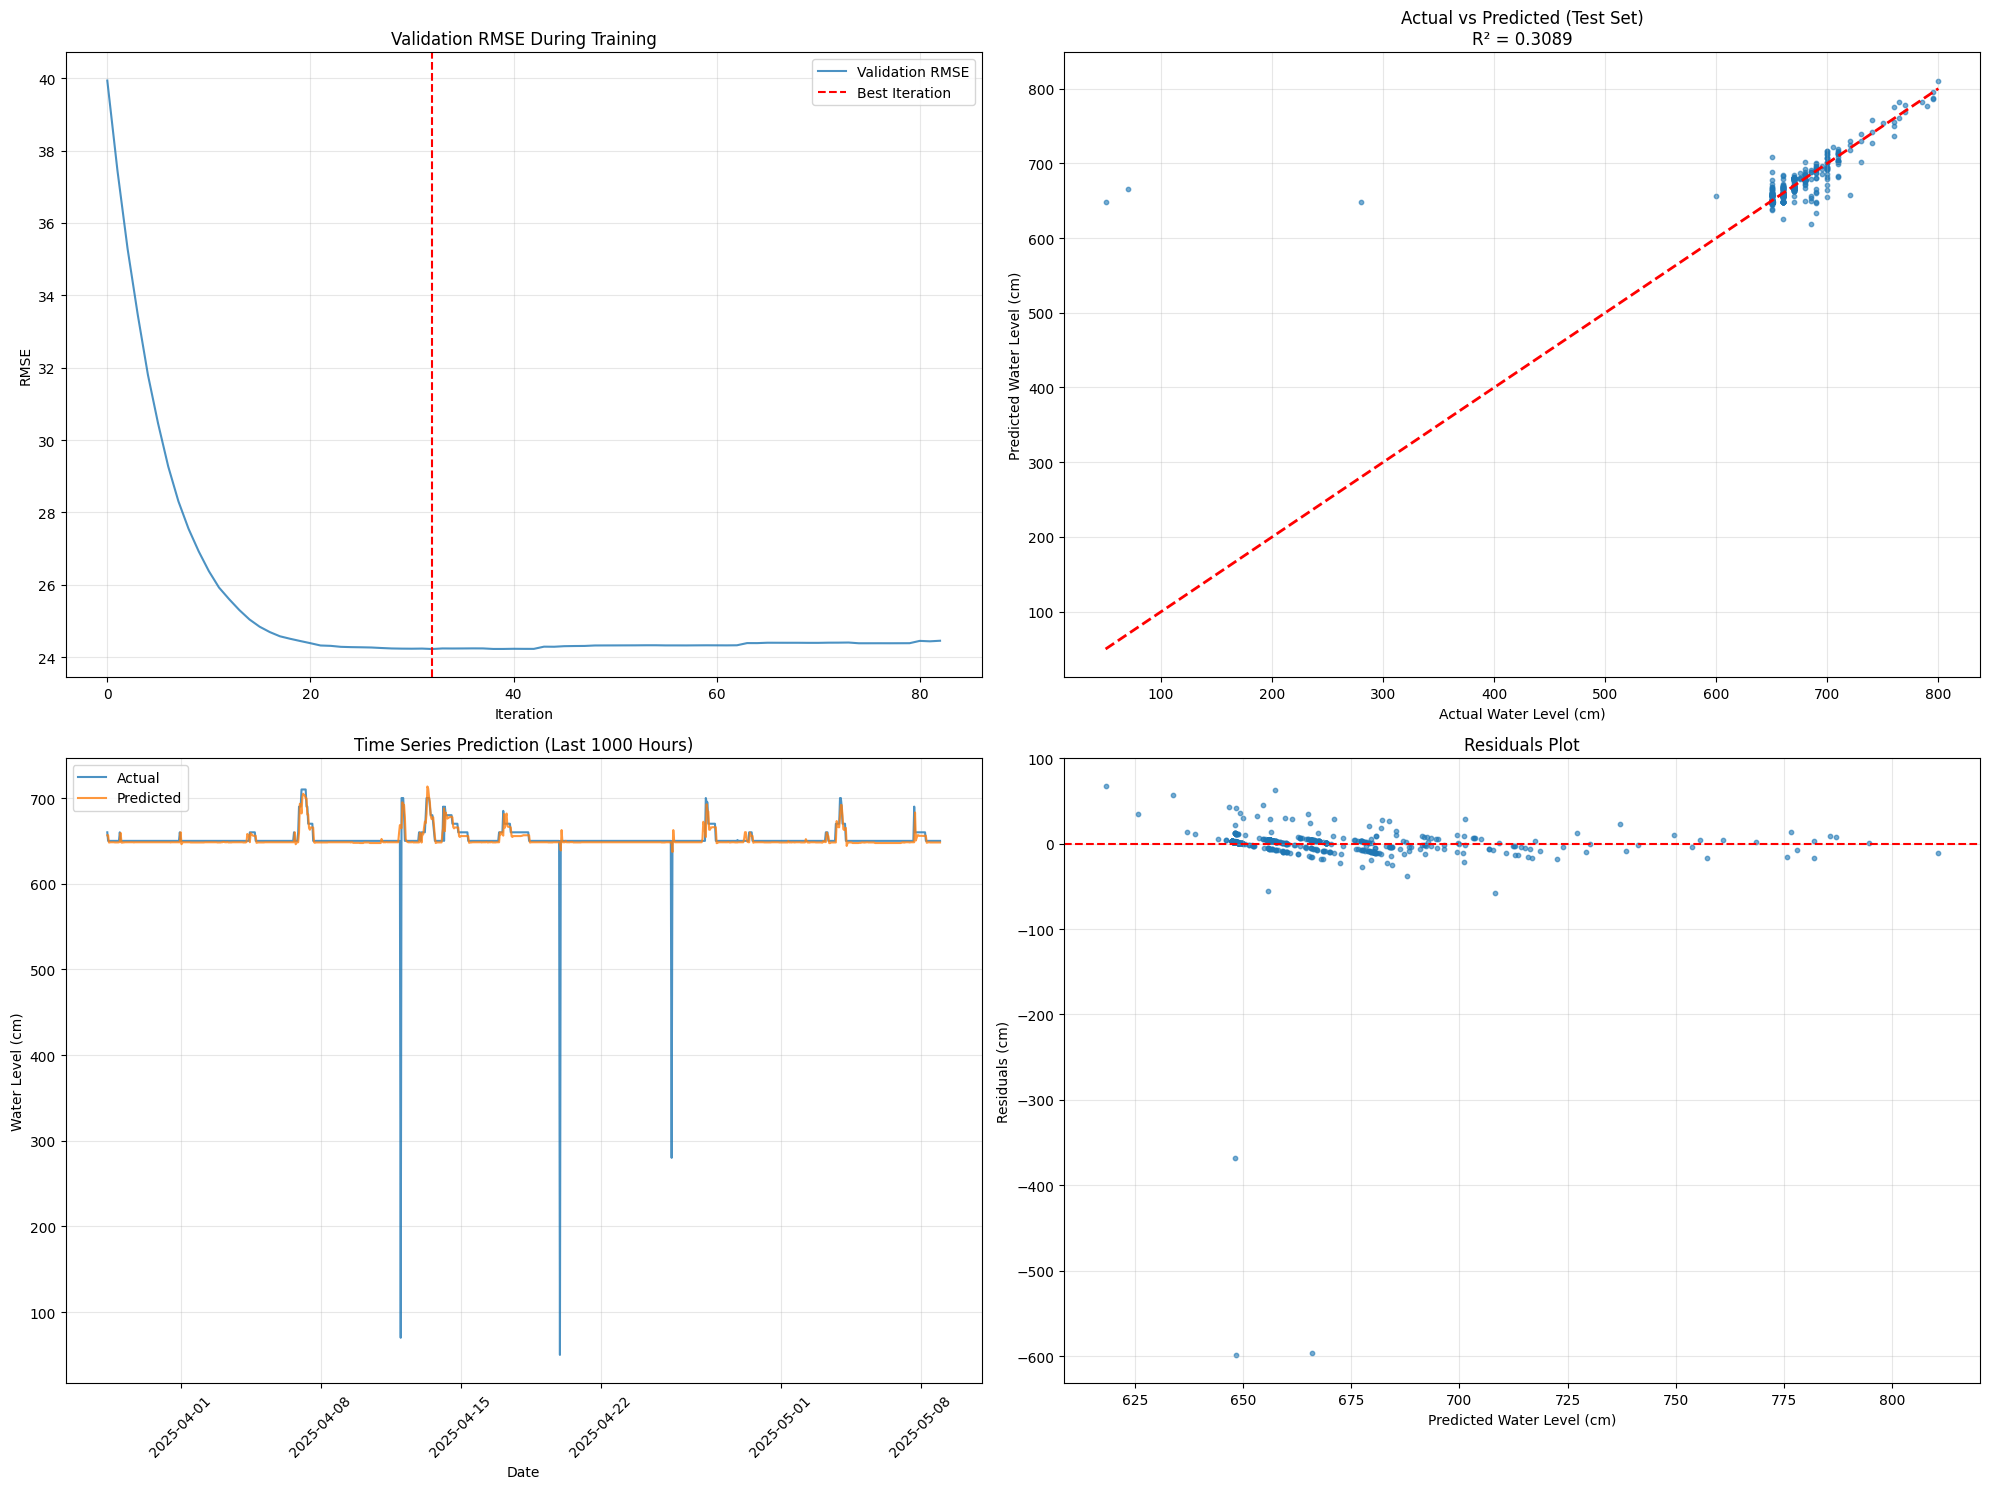

In [33]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Training and validation curves
# Check what evaluation results are available
eval_results = model.evals_result()
print("Available evaluation results:", list(eval_results.keys()))

if 'validation_0' in eval_results:
    axes[0, 0].plot(eval_results['validation_0']['rmse'], label='Validation RMSE', alpha=0.8)
    if hasattr(model, 'best_iteration') and model.best_iteration:
        axes[0, 0].axvline(x=model.best_iteration, color='red', linestyle='--', label='Best Iteration')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].set_title('Validation RMSE During Training')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    # If no evaluation results, show a simple message
    axes[0, 0].text(0.5, 0.5, 'No evaluation results available\n(Model trained without eval_set)', 
                    ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Training Progress')

# 2. Actual vs Predicted scatter plot
axes[0, 1].scatter(y_test, test_pred, alpha=0.6, s=10)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Water Level (cm)')
axes[0, 1].set_ylabel('Predicted Water Level (cm)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Time series prediction plot (last 1000 points for clarity)
plot_points = min(1000, len(test_df))
test_subset = test_df.tail(plot_points).copy()
test_pred_subset = test_pred[-plot_points:]

axes[1, 0].plot(test_subset.index, test_subset['Manggarai'], 
                label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 0].plot(test_subset.index, test_pred_subset, 
                label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Water Level (cm)')
axes[1, 0].set_title(f'Time Series Prediction (Last {plot_points} Hours)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Residuals plot
axes[1, 1].scatter(test_pred, residuals_test, alpha=0.6, s=10)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted Water Level (cm)')
axes[1, 1].set_ylabel('Residuals (cm)')
axes[1, 1].set_title('Residuals Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()